# Model exploration, checking, and comparison

An important goal of creating pyei was to facilitate the exploration, evaluation, and comparison of models for ecological inference. We wanted to make it easier to perform the kinds of checks that are typically part of a Bayesian workflow, such as prior predictive checks, posterior predictive checks, diagnostics checks for the samples, etc. This notebooks is a work in progress, meant to demonstrate some ways to use pyei to better understand the underlying models.

In [183]:
import numpy as np
import pymc3 as pm
from matplotlib import pyplot as plt
from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER, GoodmansERBayes
from pyei.data import get_data

### Load some example data

In [184]:
# Load example data
data = get_data("santaClara.csv")
X = np.array(data["pct_e_asian_vote"])
T = np.array(data["pct_for_hardy2"])
N = np.array(data["total2"])
demographic_group_name = "e_asian"
candidate_name="Hardy"
precinct_names = data['precinct']

### Set up the model

In [185]:
ei = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=8, pareto_shape=2)

#NOTE: right now, the fit function is the easiest way to set the model (ei.sim_model), which we need for the prior predictive
# But, we of course don't use the draws from the posterior in the prior predictive checks!
# Note that the prior predictive draws of votes_count *DO* depend on precinct_pops and demographic_group_fractions
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names, draw_samples=False)


### Sample from the prior predictive distribution

In [186]:
# Sample from the prior predictive distributions
with ei.sim_model as sim_model:
    prior_pred = pm.sample_prior_predictive(10000)

In [187]:
### Examine the prior predictive distribution

In [188]:
# A list of the named random variables in the model (so that we know what we can examine)
pm.util.get_default_varnames(ei.sim_model.named_vars, include_transformed=False)

['phi_1', 'kappa_1', 'phi_2', 'kappa_2', 'b_1', 'b_2', 'votes_count']

In [189]:
prior_pred['votes_count'].shape # number of prior predictive draws x num_precincts

(10000, 42)

(array([1126.,  990., 1019.,  962.,  908.,  963.,  992.,  978.,  940.,
        1122.]),
 array([  0. ,  65.8, 131.6, 197.4, 263.2, 329. , 394.8, 460.6, 526.4,
        592.2, 658. ]),
 <a list of 10 Patch objects>)

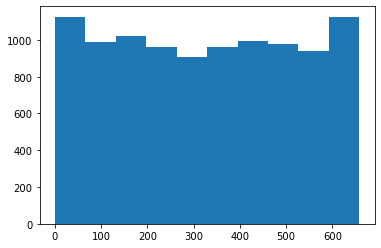

In [190]:
# plot a histogram of the prior predictive draws of the count of votes in the 0'th county
plt.hist(prior_pred['votes_count'][:,0])

(array([1325.,  897.,  930.,  915.,  931.,  976.,  899.,  940.,  912.,
        1275.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

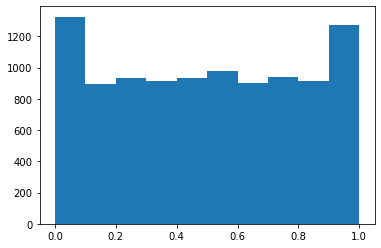

In [191]:
plt.hist(prior_pred['b_1'][:,0])

(array([1292.,  952.,  967.,  901.,  899.,  926.,  956.,  913.,  898.,
        1296.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

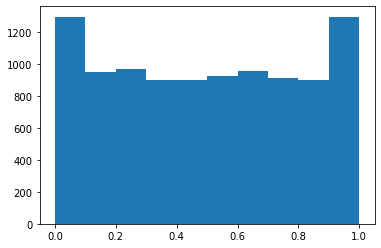

In [192]:
plt.hist(prior_pred['b_2'][:,0])

(array([9.888e+03, 7.900e+01, 1.700e+01, 4.000e+00, 5.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([  8.00032974,  81.78415955, 155.56798936, 229.35181918,
        303.13564899, 376.9194788 , 450.70330861, 524.48713842,
        598.27096823, 672.05479804, 745.83862785]),
 <a list of 10 Patch objects>)

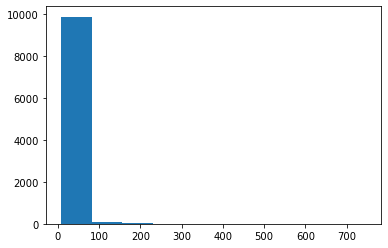

In [193]:
plt.hist(prior_pred['kappa_1'])

(array([1006., 1000.,  970.,  985., 1025., 1009., 1014., 1041.,  989.,
         961.]),
 array([1.38271079e-04, 1.00114563e-01, 2.00090856e-01, 3.00067148e-01,
        4.00043440e-01, 5.00019732e-01, 5.99996025e-01, 6.99972317e-01,
        7.99948609e-01, 8.99924901e-01, 9.99901194e-01]),
 <a list of 10 Patch objects>)

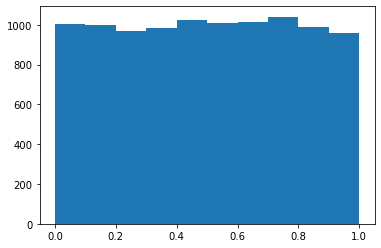

In [194]:
plt.hist(prior_pred['phi_1'])

In [195]:
# We can weight by population and obtain district-level voting preferences from the prior predictive samples, if we want
sampled_voting_prefs_gp1 = (prior_pred["b_1"] * N).sum(axis=1) / N.sum()
sampled_voting_prefs_gp2 = (prior_pred["b_2"] * N).sum(axis=1) / N.sum()


(array([1011., 1000.,  985.,  981., 1020., 1025., 1011.,  998., 1011.,
         958.]),
 array([2.7270858e-13, 1.0000000e-01, 2.0000000e-01, 3.0000000e-01,
        4.0000000e-01, 5.0000000e-01, 6.0000000e-01, 7.0000000e-01,
        8.0000000e-01, 9.0000000e-01, 1.0000000e+00]),
 <a list of 10 Patch objects>)

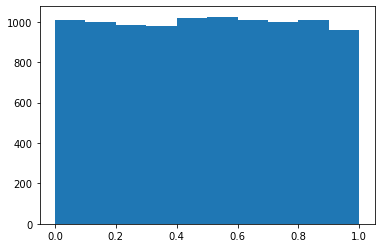

In [196]:
plt.hist(sampled_voting_prefs_gp1)

(array([ 216.,  593.,  983., 1382., 1803., 1753., 1394., 1062.,  611.,
         203.]),
 array([-0.99256247, -0.7946472 , -0.59673192, -0.39881665, -0.20090138,
        -0.00298611,  0.19492916,  0.39284444,  0.59075971,  0.78867498,
         0.98659025]),
 <a list of 10 Patch objects>)

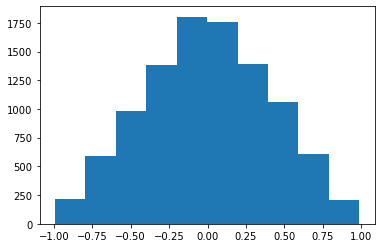

In [197]:
plt.hist(sampled_voting_prefs_gp1 - sampled_voting_prefs_gp2)

In [198]:
# We can probe, e.g., what percentage of samples from the prior predictive look polarized according to this measure
(abs(sampled_voting_prefs_gp1 - sampled_voting_prefs_gp2) > 0.1).sum()/ len(sampled_voting_prefs_gp1)

0.8102

### Fitting the model and generating posterior samples

In [ ]:
## Fitting the model
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, kappa_2, phi_2, kappa_1, phi_1]
Sampling 4 chains, 0 divergences:  81%|████████  | 11282/14000 [00:32<00:06, 423.66draws/s]

### Sample from the posterior predictive

In [ ]:
with ei.sim_model as sim_model:
    posterior_pred = pm.sample_posterior_predictive(ei.sim_trace)

In [ ]:
plt.hist(posterior_pred['votes_count'][0,:]) # Simulated vote counts for the 0th county

# Using arviz to explore the model:

Pyei works well with arviz, a library for exploratory analysis of bayesian models.


In [ ]:
import arviz as az

### We'll use the outputs of pyei and pymc and will create a data inference object that has prior predictive, posterior, and posterior predictive distributions all contained within it. 

In [ ]:
# with arviz
data = az.from_pymc3(
    trace=ei.sim_trace, #the posterior distribution
    prior=prior_pred,
    posterior_predictive=posterior_pred,
    model=ei.sim_model,
)
data

### We can look at some convergence diagnostics like rhat and the essential sample size for each variable

In [ ]:
az.ess(data)

In [ ]:
az.rhat(data)

### Traceplots

In [ ]:
az.plot_trace(data, compact=True)
# each color here is a different chain, vertical tick marks mark divergences
# Set compact = False to see each county on a different plot

In [ ]:
## We can look at posterior predictive draws
az.plot_ppc(data)

### We can compare prior and posterior distributions of variables of interest

In [ ]:
az.plot_dist_comparison(data, var_names='phi_1')

In [ ]:
#az.plot_dist_comparison(data, var_names='b_2')

In [ ]:
#data.posterior['voting_prefs_gp1'] =  ei.sampled_voting_prefs[0]

In [ ]:
#data.posterior['voting_prefs_gp2'] =  ei.sampled_voting_prefs[1]

In [ ]:
#az.plot_dist(data.posterior['voting_prefs_gp1'])

### Draws from the prior predictive distribution are one source of simulated data on which we can test our model


Note that the prior predictive distribution will use the precinct populations (here, N) and the group fractions (here X) in generating the vote counts for each county. Here we'll come up with fictional X and N before we use them to generate the votes.

This is a generous-to-the-model way to make fake data for our model -- since the data comes from the generative model itself! We also want to think about what happens if the data in the real world doesn't look much like data from the generative model.

In [ ]:
num_precincts = 10
X = np.linspace(0.1, 0.9, num_precincts)
N = 100 * np.ones(num_precincts)
T = 50 * np.ones(num_precincts) / N #ei.fit needs a vote_counts, value, even though this won't get used in the prior predictive

In [ ]:
# Sample from the prior predictive
ei.fit(X, T, N, draw_samples=False)
with ei.sim_model as model:
    prior_pred_for_simulation = pm.sample_prior_predictive()

In [ ]:
# Use one of the prior predictive samples as simulated data
sample_num = 0
simulated_vote_fraction = prior_pred_for_simulation['votes_count'][sample_num,:] / N

In [ ]:
ei.fit(X, simulated_vote_fraction, N)

In [ ]:
ei.plot()

In [ ]:
# compute true district-level voting preferences
voting_pref_gp1 = (prior_pred_for_simulation['b_1'][sample_num,:] * N).sum() / N.sum()
voting_pref_gp2 = (prior_pred_for_simulation['b_2'][sample_num,:] * N).sum() / N.sum()
print(voting_pref_gp1, voting_pref_gp2)

In [ ]:
print(ei.summary())

In [ ]:
# we can compare the inferred betas to the actual ones
prior_pred_for_simulation['b_1'][sample_num,:] #actual
b_1_posterior_means, b_2_posterior_means, b_1_credible_ints, b_2_credible_ints = ei.precinct_level_estimates() # inferred
b_1_int_lower = [x[0] for x in b_1_credible_ints]
b_1_int_upper = [x[1] for x in b_1_credible_ints]
import pandas as pd
pd.DataFrame({'actual': prior_pred_for_simulation['b_1'][sample_num,:], 'inferred': b_1_posterior_means, '95% CI lower':b_1_int_lower, '95% CI upper':b_1_int_upper})

In [ ]:
ei.precinct_level_plot()